In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.pylab import subplots
import matplotlib.mlab as mlab
import matplotlib.patches as patches
from scipy import interpolate 

In [2]:
fname='player_attributes.csv'
pl=pd.read_csv(fname)
pl['Attack']=pl.loc[:,['Crossing','Finishing','Heading Accuracy','Short Passing','Volleys']].mean(1)
pl['Skill']=pl.loc[:,['Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control']].mean(1)
pl['Movement']=pl.loc[:,['Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance']].mean(1)
pl['Power']=pl.loc[:,['Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots']].mean(1)
pl['Defending']=pl.loc[:,['Marking', 'Standing Tackle', 'Sliding Tackle']].mean(1)
pl['Goalkeeping']=pl.loc[:,[ 'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes']].mean(1)
pl['Attacking+Skill']=pl.loc[:,['Attack','Skill']].mean(1)
pl['Mentality']=pl.loc[:,['Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure']].mean(1)
ph=pl['Height'].tolist()
ph=[i.strip('""').split('\'') for i in ph]
ph=np.array([(int(i[0])*12+int(i[1]))*2.54 for i in ph])
pl['H (cm)']=ph
pw=pl['Weight'].values*0.4535924
BMI=pw/ph**2*1e4
pl['BMI']=BMI

In [3]:
plp=pl.groupby('Player Category')
sp=plp.get_group('Striker')
gp=plp.get_group('GoalKeeper')
mp=plp.get_group('Midfielder')
dp=plp.get_group('Defender')

In [4]:
pl.loc[pl.index[pl['Player Category']=='Striker'],'Mentality']=sp.loc[:,['Aggression', 'Positioning', 'Vision', 'Penalties', 'Composure']].mean(1)
pl.loc[pl.index[pl['Player Category']=='Defender'],'Mentality']=dp.loc[:,['Aggression', 'Interceptions', 'Positioning', 'Vision', 'Composure']].mean(1)
op=pd.concat([sp,mp,dp])

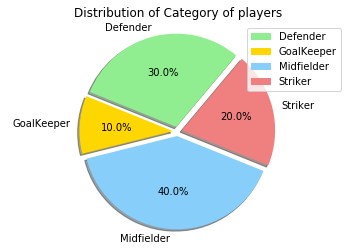

In [5]:
sizes=plp.count()['H (cm)']
explode=[0.05,0.05,0.05,0.05]
labels=['Defender','GoalKeeper','Midfielder','Striker']
colors=['lightgreen','gold','lightskyblue','lightcoral']
pie=plt.pie(sizes,explode=explode, shadow=True,labels=labels,colors=colors,autopct='%1.1f%%',startangle=50)
plt.axis('equal')
plt.title('Distribution of Category of players')
plt.legend()

In [6]:
opH=op.groupby('H (cm)').mean()
opW=op.groupby('Weight').mean()
opB=op.groupby('BMI').mean()
gpH=gp.groupby('H (cm)').mean()
gpW=gp.groupby('Weight').mean()
gpB=gp.groupby('BMI').mean()

In [7]:
def ddraw(item,unit=''):
    x=pl[item]
    bins = np.linspace(x.min(),x.max(),10)
    x1 = np.linspace(x.min(), x.max(), 100)
    normal = norm.pdf(x1, x.mean(), x.std())*x.count()*(bins[1]-bins[0])
    kde = mlab.GaussianKDE(x)
    p1=plt.hist([dp[item],mp[item],sp[item],gp[item]], bins = bins,rwidth=0.8,edgecolor = 'k',stacked= True,label=['Defender','Midfielder','Striker','GoalKeeper'])
    plt.plot(x1,kde(x1)*x.count()*(bins[1]-bins[0]),linewidth = 3,label='Kernel density')
    plt.plot(x1,normal,label='Normal distribution',linewidth = 3)
    plt.grid(True)
    plt.xlabel(item+unit)
    plt.ylabel('Number of players')
    plt.legend(loc= 'best')
    plt.title('Distribution of '+item)

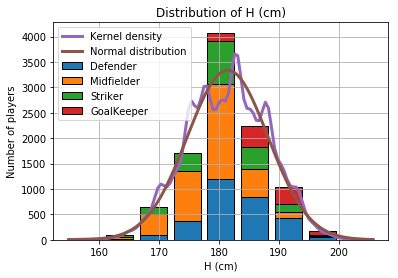

In [8]:
ddraw('H (cm)')

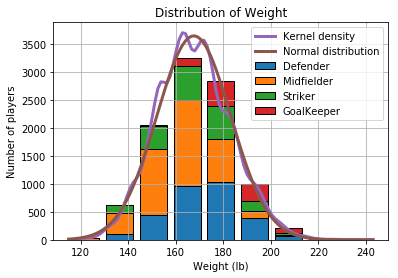

In [9]:
ddraw('Weight',' (lb)')

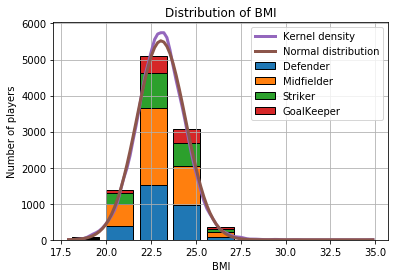

In [10]:
ddraw('BMI')

In [11]:
def ptt(x,item,ply):
    fig,axs=subplots(1,3,figsize=(20, 5))
    for i in range(3):
        x1=x[i].index.values
        y1=x[i][item].values
        z1 = np.polyfit(x1, y1, 7)
        p1 = np.poly1d(z1)
        xv=np.linspace(min(x1),max(x1),100)
        yv=p1(xv)
        xname=x[i].index.name
        dx=ply[xname]
        normal = norm.pdf(xv, dx.mean(), dx.std())
        normal=normal+max(normal)/4
        ax=axs[i]
        ax.plot(xv, yv, '--')
        d=xv[1]-xv[0]    
        for j in range(99):
            ax.add_patch(patches.Rectangle((xv[j],0),d,yv[j],color='dodgerblue',linewidth=0,alpha=normal[j]/max(normal)))  
        ax.set_xlabel(xname+' (lb)'*(xname=='Weight'))    
        ax.set_ylabel(item)
        ax.set_title(item +' vs '+xname)    
        ax.grid(True)
        ax.set_ylim([min(yv)-5,max(yv)+5])
        


In [12]:
def pt(x,item,ply):
    fig,axs=subplots(1,3,figsize=(20, 5))
    for i in range(3):
        x1=x[i].index.values
        y1=x[i][item].values
        xv=np.linspace(min(x1),max(x1),100)
        fl=interpolate.interp1d(x1, y1)
        xname=x[i].index.name
        dx=ply[xname]
        normal = norm.pdf(xv, dx.mean(), dx.std())
        normal=normal+max(normal)/4
        ax=axs[i]
        d=xv[1]-xv[0]    
        for j in range(99):
            ax.add_patch(patches.Rectangle((xv[j],0),d,fl(xv[j]),color='dodgerblue',linewidth=0,alpha=normal[j]/max(normal)))  
        ax.plot(x1, y1, '--')
        ax.set_xlabel(xname+' (lb)'*(xname=='Weight'))    
        ax.set_ylabel(item)
        ax.set_title(item +' vs '+xname)    
        ax.grid(True)
        ax.set_ylim([min(y1)-5,max(y1)+5])
        

untreatened data is the one below


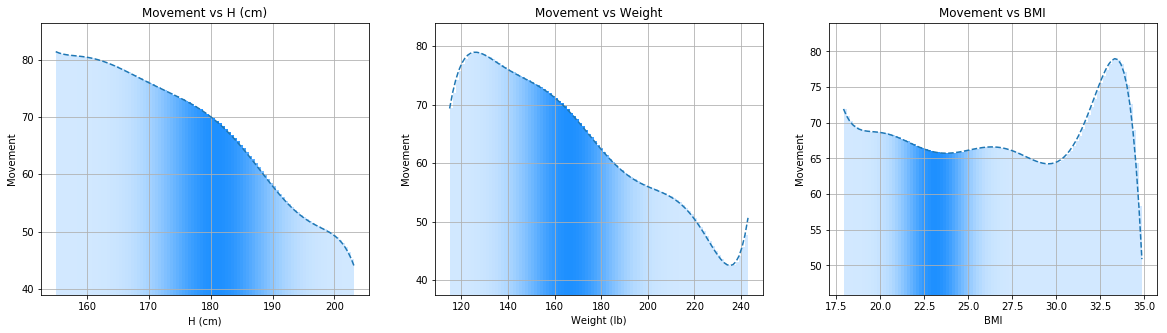

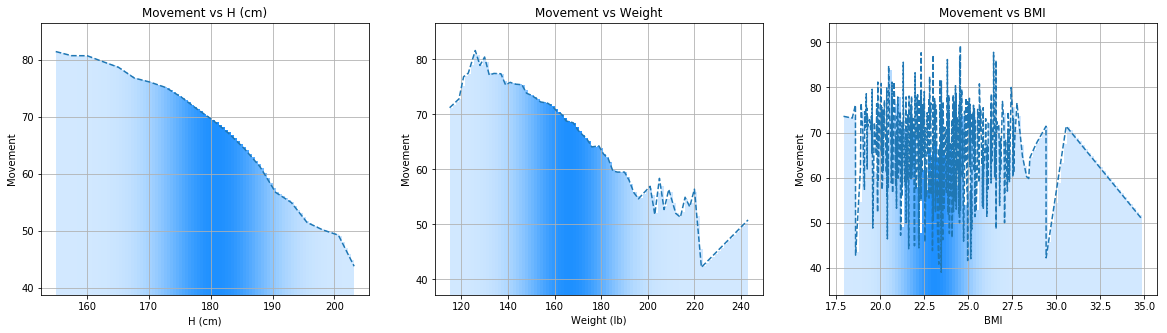

In [13]:
x=[opH,opW,opB]
ply=pd.concat([sp,mp,dp])
ptt(x,'Movement',ply)
print('untreatened data is the one below')
pt(x,'Movement',ply)

untreatened data is the one below


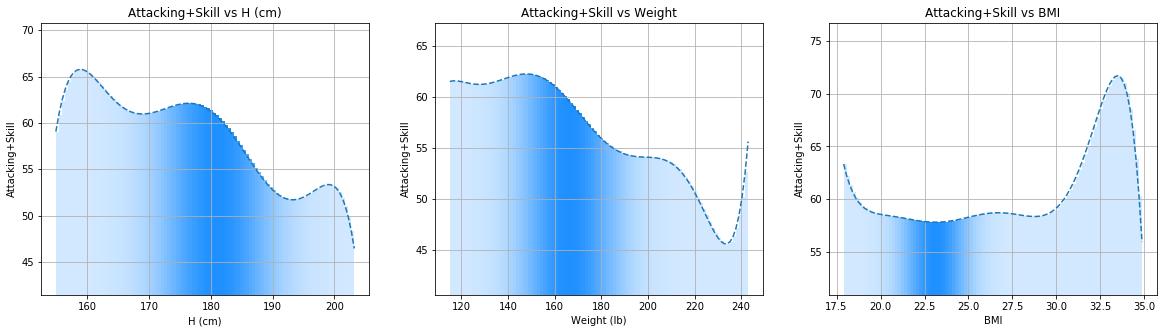

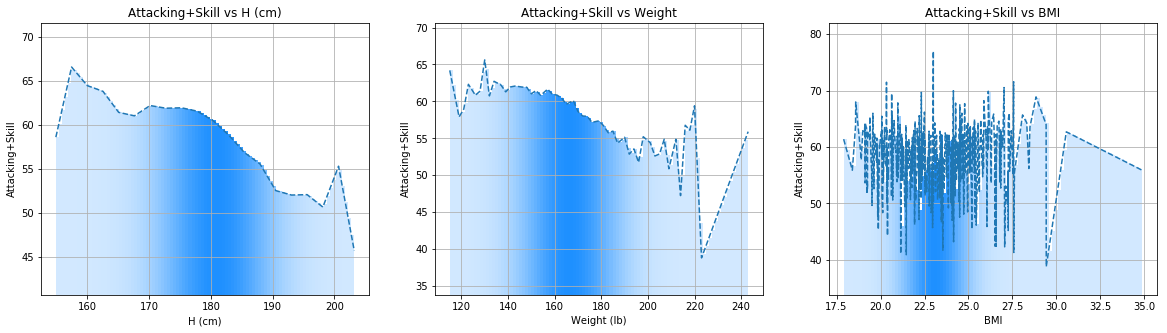

In [14]:
ptt(x,'Attacking+Skill',ply)
print('untreatened data is the one below')
pt(x,'Attacking+Skill',ply)

untreaten data is the one below


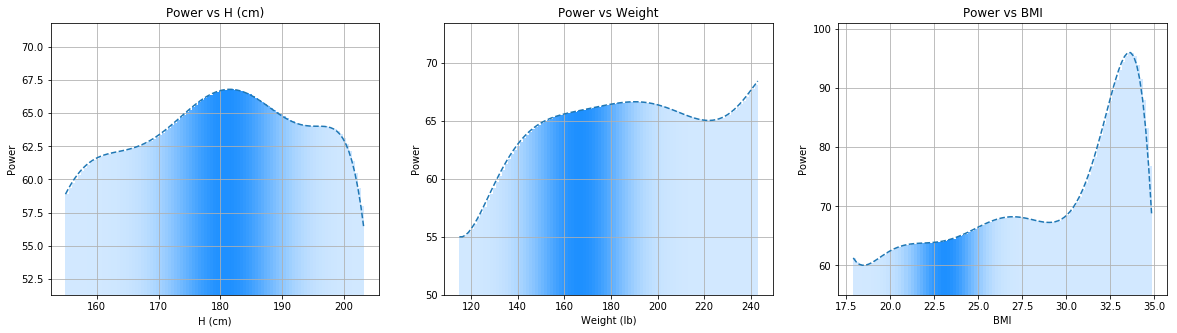

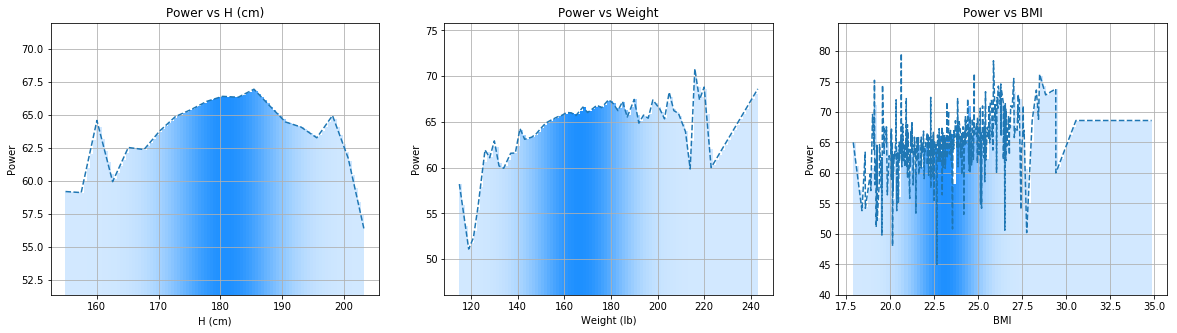

In [15]:
ptt(x,'Power',ply)
print('untreaten data is the one below')
pt(x,'Power',ply)

untreaten data is the one below


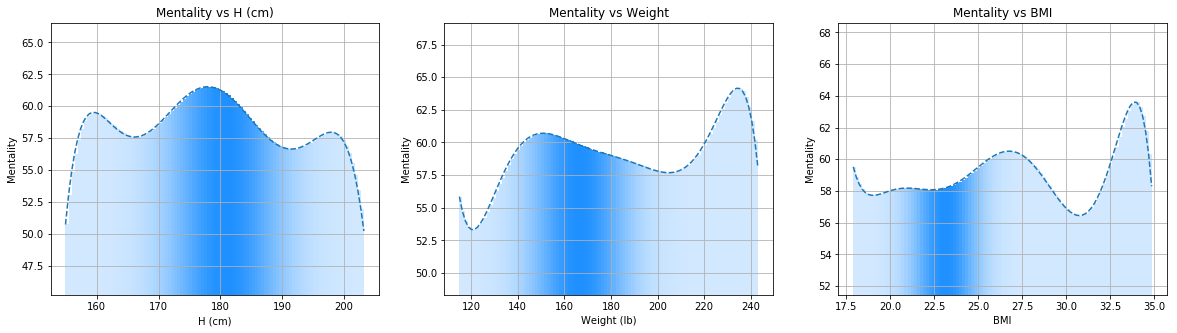

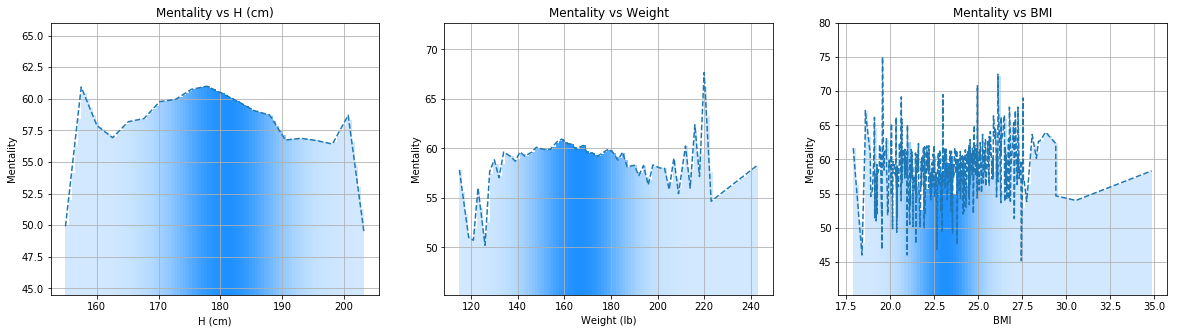

In [16]:
ptt(x,'Mentality',ply)
print('untreaten data is the one below')
pt(x,'Mentality',ply)

untreaten data is the one below


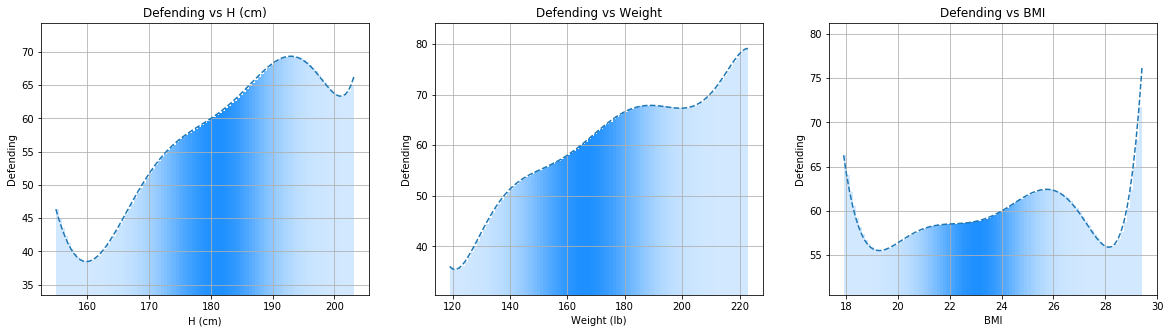

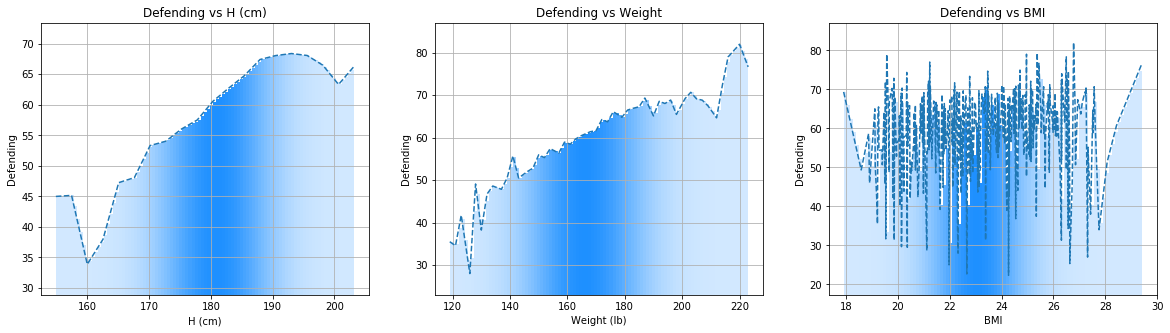

In [17]:
oop=pd.concat([mp,dp])
oopH=oop.groupby('H (cm)').mean()
oopW=oop.groupby('Weight').mean()
oopB=oop.groupby('BMI').mean()
x=[oopH,oopW,oopB]
ptt(x,'Defending',oop)
print('untreaten data is the one below')
pt(x,'Defending',oop)

untreaten data is the one below


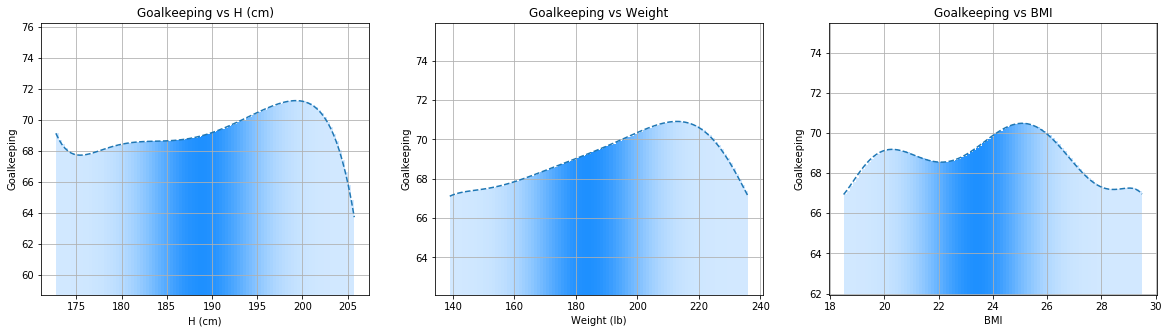

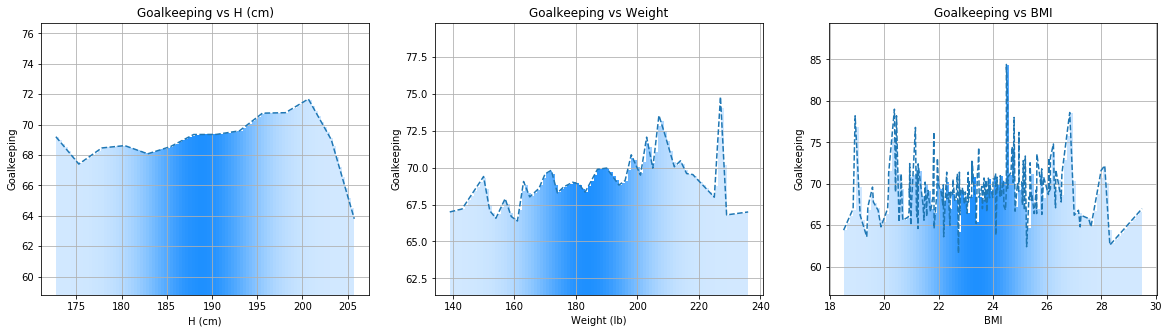

In [18]:
x=[gpH,gpW,gpB]
ptt(x,'Goalkeeping',gp)
print('untreaten data is the one below')
pt(x,'Goalkeeping',gp)